In [1]:
import ctypes
import numpy as np
import csv
from matplotlib import pyplot as plt
import sys
import os


## Load in data

In [2]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"
#oh_path = f"{data_path}/alphabets_blosum_coordinates/MSE/MSE.npz"
#blosum_path = f"{data_path}/alphabets_blosum_coordinates/MSE/MSE.npy"
oh_path = f"{data_path}/alphabets_blosum_coordinates/3Di/3Di.npz"
blosum_path = f"{data_path}/alphabets_blosum_coordinates/3Di/3Di.npy"
train_path = f"{data_path}/train_test_val/train.csv"

In [3]:
oh_d = np.load(oh_path)
blosum = np.load(blosum_path).astype(int)
training_names = [row[0] for row in csv.reader(open(train_path, newline=''))]

## Function that calls C code for computing lambda and K

In [4]:
# Load the shared library
lib = ctypes.CDLL('./psublast/libkarlin.so')  # For Windows use '.dll' instead of '.so'



# Define the C function prototype
lib.karlin.argtypes = [
    ctypes.c_int,                   # low (int)
    ctypes.c_int,                   # high (int)
    ctypes.POINTER(ctypes.c_double),# pr (double *)
    ctypes.POINTER(ctypes.c_double),# lambda (double *)
    ctypes.POINTER(ctypes.c_double) # K (double *)
]

lib.karlin.restype = ctypes.c_int    # Return type int

# Python function to call the C function
def call_karlin(low, high, pr_array):
    # Convert pr_array to a ctypes array
    pr = (ctypes.c_double * len(pr_array))(*pr_array)
    
    # Prepare ctypes variables to hold lambda and K
    lambda_val = ctypes.c_double()
    K_val = ctypes.c_double()
    
    # Call the C function
    result = lib.karlin(low, high, pr, ctypes.byref(lambda_val), ctypes.byref(K_val))
    
    if result != 1:
        raise RuntimeError("C function failed")
    
    # Return the computed lambda and K
    return lambda_val.value, K_val.value



# Compute frequencies of each score; run C code

In [5]:
# compute frequency of letters on training set
A = blosum.shape[0]
counts = np.zeros(A)
for name in training_names:
    try:
        counts += np.sum(oh_d[name], axis = 0)
    except:
        print(f"skipping {name}, not in oh_d")

skipping d1o7d.3, not in oh_d


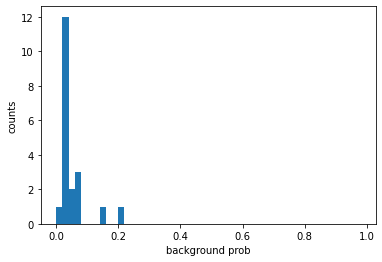

In [6]:
background_probs = counts/np.sum(counts)
plt.hist(background_probs, bins = np.arange(0,1,.02))
plt.xlabel("background prob")
plt.ylabel("counts")
plt.show()

In [7]:
low = np.min(blosum)
high = np.max(blosum)
print(low,high)
probs = np.zeros(high-low +1)


-17 10


In [8]:
for i in range(A):
    for j in range(A):
        probs[blosum[i,j]-low] += background_probs[i]*background_probs[j]
print(probs)
print(np.sum(probs))
        

[0.00049211 0.00660876 0.01011775 0.00394956 0.01016498 0.01363762
 0.01867133 0.01837697 0.02723538 0.01638292 0.03446626 0.05862708
 0.05644269 0.08312119 0.11380365 0.08963852 0.07873698 0.14349429
 0.087532   0.01820536 0.05522541 0.02920256 0.00400918 0.01652886
 0.00208786 0.00158961 0.00150542 0.00014568]
0.9999999999999999


In [9]:
lam, k = call_karlin(low, high, probs)
print(lam, k)

0.3443836271762848 0.2201812227331936


In [10]:
lam, k = call_karlin(low, high, probs)
print(lam, k)

0.3443836271762848 0.2201812227331936


## check manually for the hardcoded FS backgrounds

In [56]:
fs_backgrounds = [float(_) for _ in "0.0489372 0.0306991 0.101049 0.0329671 0.0276149 0.0416262 0.0452521 0.030876 0.0297251 0.0607036 0.0150238 0.0215826 0.0783843 0.0512926 0.0264886 0.0610702 0.0201311 0.215998 0.0310265 0.0295417 0.00001".split(" ")]

(array([ 2., 10.,  4.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98]),
 <BarContainer object of 49 artists>)

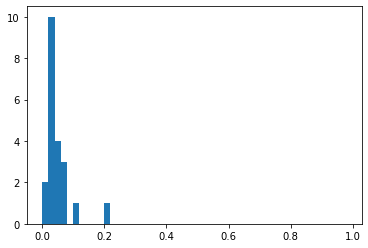

In [57]:
plt.hist(fs_backgrounds, bins = np.arange(0,1,.02))

In [59]:
low = np.min(blosum)
high = np.max(blosum)
print(low,high)
probs = np.zeros(high-low +1)

for i in range(A):
    for j in range(A):
        probs[blosum[i,j]-low] += fs_backgrounds[i]*fs_backgrounds[j]
print(probs)
print(np.sum(probs))

-17 10
[0.00099058 0.00831422 0.01284112 0.00455307 0.01606672 0.01855291
 0.0239089  0.02556385 0.03021638 0.01938236 0.04113213 0.0727263
 0.06377316 0.07258392 0.10407773 0.08240611 0.06878559 0.13546353
 0.07248688 0.01666552 0.06124516 0.01974455 0.00447546 0.01647706
 0.00215614 0.00232123 0.00284312 0.00022571]
0.99997940010609


In [60]:
lam, k = call_karlin(low, high, probs)
print(lam, k)

0.3515685796737671 0.2323420514526176


In [ ]:
# this matches FS number 0.351568